# Rainfall erosivity
Rainfall erosivity (the R-factor) quantifies the erosive force of rainfall and is a key parameter in soil erosion models such as the Revised Universal Soil Loss Equation (RUSLE). It is typically expressed in units of MJ·mm·ha⁻¹·h⁻¹·yr⁻¹ and requires high-resolution precipitation data for accurate estimation. This notebook covers methods for calculating the R-factor using:
- High-resolution (e.g., 10-minute) rainfall data
- Daily rainfall data (using the Modified Fournier Index and empirical equations)


## How to estimate the rainfall erosivity?
The R-factor is based on the product of storm kinetic energy ($E$) and the maximum 30-minute rainfall intensity ($I_{30}$):

$$
R = sum (E I_{30})
$$

### Considerations:
- **Regional Variations**: The relationship between rainfall depth and erosivity varies significantly by region due to differences in rainfall patterns, raindrop size, and other factors. Therefore, it's crucial to use methods and equations that are appropriate for the specific location.
- **Data Quality**: The accuracy of the R-factor estimation depends on the quality and reliability of the precipitation data.
- **Long-Term Averages**: The RUSLE R-factor represents a long-term average, so it's essential to use data from a sufficiently long period (e.g., 20 years or more) to obtain a reliable estimate.

Here's a step-by-step implementation to calculate the R-factor from 10-minute rainfall data in an Excel file, following the RUSLE methodology

## Import the necessary libraries and iMPACT-tools    

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Dropdown
os.chdir('..') # change the current working directory to the parent directory
from iMPACTools.rainfall import calculate_ei30

## Load and plot rainfall data

In [3]:
# Get list of case studies (folders in the Case_studies directory)
case_study = Dropdown(options=os.listdir('Case_studies'),description='Case Study:')
display(case_study)  

Dropdown(description='Case Study:', options=('Montefrio', 'SantaCruz'), value='Montefrio')

<AxesSubplot:xlabel='datetime'>

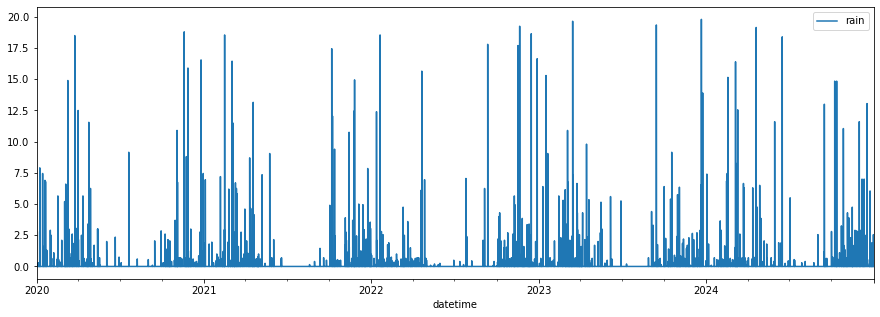

In [5]:
# Load example data (temporal resoluction = 10 minutes) 
file_path = f'Case_studies/{case_study.value}/climate/Example_10min_rainfall_data_2020_2024.xlsx'
rainfall_data = pd.read_excel(file_path, parse_dates=['datetime'], index_col='datetime')
rainfall_data = rainfall_data.dropna(subset=['rain'])
# Plot data
rainfall_data.plot(y='rain',figsize=(15, 5))

## Estimate the rainfall erosivity

In [ ]:
# --- Identify erosive events (Renard 1997 criteria) ---
# Compute 6h moving rainfall to detect breaks
rainfall_data['DryGap'] = rainfall_data['rain'].rolling('6H').sum().fillna(0)
rainfall_data['TimeDiff'] = rainfall_data.index.to_series().diff().dt.total_seconds() / 3600
rainfall_data['NewEvent'] = (rainfall_data['TimeDiff'] > 6) | (rainfall_data['DryGap'] < 1.27)
rainfall_data['Event'] = rainfall_data['NewEvent'].cumsum()

# --- EI30 calculation function ---
def calculate_ei30(event_group):
    total_rain = event_group['rain'].sum()
    max_15 = event_group['rain'].rolling(3, min_periods=1).sum().max()
    max_30 = event_group['rain'].rolling(6, min_periods=1).sum().max()
    
    # Check erosive event criteria
    if (total_rain < 12.7) and not ((max_15 >= 6.35) or (max_30 >= 12.7)):
        return 0.0
    
    # Intensities
    I10 = event_group['rain'] / (10/60)  # mm/h
    ir = I10  # interval intensity
    
    # Unit rainfall energy (MJ/ha/mm)
    er = 0.29 * (1 - 0.72 * np.exp(-0.05 * ir))
    vr = event_group['rain']  # mm per interval
    
    # Total event energy
    E = (er * vr).sum()
    
    # Max 30-min intensity (sum of 3 consecutive 10-min intensities)
    I30 = I10.rolling(3, min_periods=1).sum().max()
    
    return E * I30 if pd.notnull(I30) else 0.0

# Compute EI30 for all events
ei30_events = rainfall_data.groupby('Event').apply(calculate_ei30).rename('EI30')

# Map events to year
event_years = rainfall_data.groupby('Event').apply(lambda g: g.index[0].year)
annual_r_factor = ei30_events.groupby(event_years).sum()

# --- Normalise to 30-min resolution (Panagos et al. 2015) ---
annual_r_factor_30 = 0.8205 * annual_r_factor  # correction for 10-min data

# Mean annual R
mean_annual_r = annual_r_factor_30.mean()
print(f"Mean Annual R-Factor: {mean_annual_r:.2f} MJ·mm·ha⁻¹·h⁻¹·yr⁻¹")

## What if we only have daily or monthly precipitation data available?
Estimating the rainfall erosivity using daily or monthly precipitation data can be complex, as the ideal calculation relies on high-resolution rainfall intensity data. 

Daily and monthly precipitation data lack the necessary intensity information. This means we must rely on empirical relationships and approximations. The Modified Fournier Index and empirical equations are common approaches.

### Modified Fournier Index (MFI)
- This index uses monthly and annual rainfall data to estimate erosivity.   
- It's a common approach when detailed intensity data is unavailable.   
- Equations relating MFI to the R-factor have been developed for various regions.
- This method is very useful when only daily total rainfall amounts are available. By summing the daily amounts, monthly, and annual amounts can be found.

\$
MFI = \frac{\sum_{i=1}^{12} P_i^2}{P}
\$

Where:
- $P_i$ = total precipitation in month \(i\) (mm), derived from summing daily data for each month.
- $P$ = total annual precipitation (mm).

Then, relate $F$ to $R$ using a regional regression equation, such as:

$
R = a \cdot MFI^b
$

or 

$
R = a \cdot MFI - b
$

Where $a$ and $b$ are coefficients specific to your region (you’ll need local calibration data or references from RUSLE documentation or studies in your area).

One widely cited equation (Renard & Freimund, 1994; adapted in European studies) is:

$
R = 38.46 \cdot MFI - 320
$

To apply this:
1. Sum daily precipitation into monthly totals ($P_i$).
2. Calculate \(MFI\) using the formula above.
3. Use the region-specific $a$ and $b$ values to estimate $R$.

In [6]:
# Load daily rainfall data
file_path = "Case_studies/Montefrio/climate/Daily_Rain_1996_2021_fill.xlsx"
rainfall_data = pd.read_excel(file_path, parse_dates=['date'], index_col='date')

# Ensure rainfall column is named 'rainfall_mm'
rainfall_data = rainfall_data.dropna(subset=['rain'])

# Compute monthly totals
monthly_rain = rainfall_data['rain'].resample('M').sum()

# Group by year
def compute_mfi(group):
    # Monthly rainfall
    monthly = group.values
    P = monthly.sum()  # annual total
    if P == 0:
        return np.nan
    MFI = np.sum(monthly**2) / P
    return MFI

mfi_by_year = monthly_rain.groupby(monthly_rain.index.year).apply(compute_mfi)

# Convert MFI → R-factor using empirical relationship (Panagos et al. / Renard & Freimund 1994)
r_factor_by_year = 38.46 * mfi_by_year - 320

# Compute average R-factor
mean_r = r_factor_by_year.mean()

print("Modified Fournier Index (MFI) by year:")
print(mfi_by_year)
print("\nEstimated R-factor by year (MJ·mm·ha⁻¹·h⁻¹·yr⁻¹):")
print(r_factor_by_year)
print(f"\nMean Annual R-Factor: {mean_r:.2f} MJ·mm·ha⁻¹·h⁻¹·yr⁻¹")

Modified Fournier Index (MFI) by year:
date
1996    175.256432
1997    155.925690
1998     61.234161
1999    106.702413
2000    163.822525
2001    118.776541
2002     91.428248
2003    110.156420
2004     71.990964
2005     47.787430
2006     57.965501
2007    128.297220
2008    163.421330
2009    194.244430
2010    162.830556
2011     73.897794
2012    213.448288
2013    179.041653
2014    196.481497
2015    106.116330
2016    106.360976
2017     65.004947
2018    175.858255
2019    131.702429
2020     87.348563
2021    127.289416
Name: rain, dtype: float64

Estimated R-factor by year (MJ·mm·ha⁻¹·h⁻¹·yr⁻¹):
date
1996    6420.362378
1997    5676.902029
1998    2035.065815
1999    3783.774805
2000    5980.614315
2001    4248.145776
2002    3196.330408
2003    3916.615908
2004    2448.772483
2005    1517.904573
2006    1909.353161
2007    4614.311066
2008    5965.184338
2009    7150.640797
2010    5942.463192
2011    2522.109138
2012    7889.221163
2013    6565.941960
2014    7236.678356


### Limitations
- Daily data underestimates R compared to high-resolution (e.g., 30-minute) data because it misses peak intensities.
- Accuracy improves with region-specific equations and longer datasets.
